In [2]:
import sys
sys.path.append("../")

In [3]:
import random

INTERVAL_LOW = 0
INTERVAL_HIGH = 100
SAMPLES = int(1e5)

a = 0.04
b = 0.0005
c = 0.2
d = 0.004
normalization_factor = 100

def system(y, t,a,b,c,d):
    X, Y = y   
    dXdt =  X*(a - b*Y) 
    dYdt = -Y*(c - d*X)
    return dXdt, dYdt

def get_time_norm_function(function, max_time):
    def function_norm_time(t):
        return function(t * max_time)

    return function_norm_time


def initial_conditions_lotka(population_size, number_of_initial_conditions):
    def generate_initial_conditions(population_size):
        N = population_size
        x = random.randint(1,N -1)
        y = N - x
        return  [x,y]
    
    yield [population_size//2,population_size//2]
    for i in range(number_of_initial_conditions -1):  
        yield generate_initial_conditions(population_size)

include_time = True
# The ideal trained neural network model
class ExactModel:
    def eval_model(self, X):
        if include_time:
            return [X[1]* normalization_factor * (a - b * X[2] * normalization_factor)]
        else:
            return [X[0]* normalization_factor * (a - b * X[1] * normalization_factor)]
#         if include_time:
#             return [-X[2]* normalization_factor * (c - d * X[1] * normalization_factor)]
#         else:
#             return [-X[1]* normalization_factor * (c - d * X[0] * normalization_factor)]

exact = ExactModel()

Generating training data...
[25, 25]
[40, 10]
[32, 18]
[43, 7]
[46, 4]
[40, 10]
[20, 30]
Done


Text(0.5, 1.0, 'y(t)')

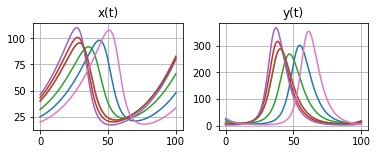

In [5]:
from interpolation.interpolate_system import odeint_interpolate
from interpolation.regression_dataset import RegressionDataset

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np


number_of_systems = 7
samples_per_system = 14285
population_size = 50

dataset_train = None
dataset_test = None


print("Generating training data...")

figure = plt.figure()
gs1 = gridspec.GridSpec(10,11)
ax11 = figure.add_subplot(gs1[:5, :5])
ax12 = figure.add_subplot(gs1[:5, 6:])

for init_conditions in initial_conditions_lotka(population_size, number_of_systems):
    # Interpola el sistema tomando muestras en un intervalo uniforme 
    y_inter = odeint_interpolate( system, init_conditions, INTERVAL_LOW, INTERVAL_HIGH, 10000, (a,b,c,d))
    # Normaliza con respecto al tiempo las funciones obtenidas 
    y_inter_time_norm = [get_time_norm_function(yi, INTERVAL_HIGH) for yi in y_inter]
    
    t = np.linspace(INTERVAL_LOW, INTERVAL_HIGH, 10000)
    X,Y = y_inter

    ax11.plot(t, [X(ti) for ti in t])
    ax12.plot(t, [Y(ti) for ti in t])
    
    print(init_conditions)
    
    def y_prime(t): # Funcion exacta que se quiere aproximar con la red neuronal
        return y_inter_time_norm[0](t) * (a - b * y_inter_time_norm[1](t))
#         return -y_inter_time_norm[1](t) * (c - d * y_inter_time_norm[0](t))
    
    # Generando datasets de entrenamiento y prueba para cada conjunto de condiciones iniciales
    d_train = RegressionDataset(y_inter_time_norm, y_prime, normalization_factor, samples_per_system * 80 // 100, include_time)
    d_test = RegressionDataset(y_inter_time_norm, y_prime, normalization_factor, samples_per_system * 20 // 100, include_time)
   
    if dataset_train:
        dataset_train.concat_dataset(d_train)
        dataset_test.concat_dataset(d_test)
    else:
        dataset_train = d_train
        dataset_test = d_test




print("Done")
ax11.grid()
ax12.grid()
ax11.set_title("x(t)")
ax12.set_title("y(t)")
# axes[0].grid()
# axes.legend()
# plt.savefig('lotka_volterra_example_two_initial_conditions.png')


In [11]:
%load_ext autoreload
%autoreload 2
from interpolation.regression_nn import RegressionNN
m1 = RegressionNN.nn_dataset_regression(dataset_train, dataset_test,1000,20)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
NVIDIA GeForce RTX 3050 Ti Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
epoch: 0
train_loss: 1.8462086877225392
test_loss: 0.6943405497955691
epoch: 10
train_loss: 0.011390919559884532
test_loss: 0.0026003807555228815
train_loss: 0.0004820606273103374
test_loss: 0.001953960050288041


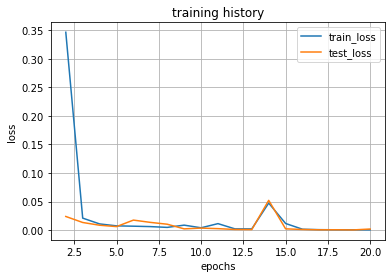

In [12]:
m1.plot_learn_history(1,20)

In [20]:
%load_ext autoreload
%autoreload 2
from query_set.check_var_exist import check_var_exist_grad_dataset
import math

def rmsValue(arr, n):
    square = 0
    mean = 0.0
    root = 0.0
     
    #Calculate square
    for i in range(0,n):
        square += (arr[i]**2)
     
    #Calculate Mean
    mean = (square / (float)(n))
     
    #Calculate Root
    root = math.sqrt(mean)
     
    return root

n = min(100000, len(dataset_train.X))

values = check_var_exist_grad_dataset(m1, 0, dataset_train)
print(rmsValue(values, n))


values = check_var_exist_grad_dataset(m1, 1, dataset_train)
print(rmsValue(values, n))


values = check_var_exist_grad_dataset(m1, 2, dataset_train)
print(rmsValue(values, n))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.024061502860483322
4.412906765004076
2.833200681294181


In [21]:
%load_ext autoreload
%autoreload 2
from query_set.regression_dependency import check_polynomial_dependency

y_inter = odeint_interpolate( system, [20, 20], INTERVAL_LOW, INTERVAL_HIGH, 10000, (a,b,c,d) )
y_inter_time_norm = [get_time_norm_function(yi, INTERVAL_HIGH) for yi in y_inter]

result = check_polynomial_dependency(
        m1,
        1,
        y_inter_time_norm,
        0.25,
        0.5,
        3,
        normalization_factor,
        25,
        1000,
        include_time)

print(result)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'polynomial': [1.9889598704376232e-06, 0.00032049474496152237, 0.019469618090620183, 0.3428905051928399], 'determination': 0.9999996216557491}
